In [5]:
import re
from difflib import SequenceMatcher
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
movies=pd.read_csv('/content/gdrive/MyDrive/movie-recommendation-dataset/movies.csv')
movies=movies.drop(['genres'],axis='columns')

In [8]:
ratings=pd.read_csv('/content/gdrive/MyDrive/movie-recommendation-dataset/ratings.csv')
ratings=ratings.drop(['timestamp'],axis='columns')

In [9]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [10]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [11]:
ratings['rating'].sort_values().unique()

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [12]:
movies.values.shape[0]

9742

In [13]:
ratings.values.shape[0]

100836

In [14]:
ratings['userId'].nunique()

610

# **Data preprocessing and visualization**

The long tail property

A general trend observed and buisness is that a small perscentage of entitiles are highly popular and the rest are not popular

### **set threshold for popular movies and active users**

In [15]:
popular_movies_thresh=25
active_users_thresh=100

### **Vizualise the long-tail property for popurlar movies**

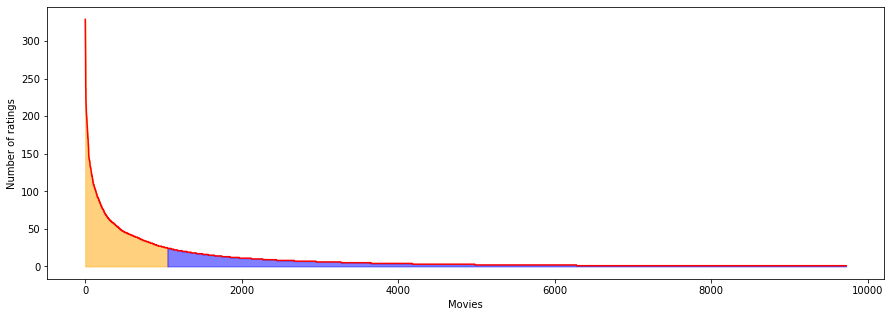

In [16]:
movies_count = pd.DataFrame(ratings.groupby('movieId').size().sort_values(ascending=False), columns=['count'])
divider = len(movies_count.query('count >= @popular_movies_thresh'))
fig, (ax) = plt.subplots(1, 1, figsize=(15,5))
plt.plot(np.arange(len(movies_count)),movies_count['count'], color='red')
plt.xlabel('Movies')
plt.ylabel('Number of ratings')

ax.fill_between(np.arange(0,divider),
                0,
                movies_count['count'][:divider],
                color='orange',
                alpha=0.5)
ax.fill_between(np.arange(divider, len(movies_count)),
                0,
                movies_count['count'][divider:],
                color='blue',
                alpha=0.5)

### Remove unpopular movies frm data

In [17]:
popular_movies_indices=movies_count.query('count >= @popular_movies_thresh').index
popular_ratings = ratings[ratings['movieId'].isin(popular_movies_indices)]

**Number of rows in original ratings data**

In [18]:
ratings.shape[0]

100836

**Number of rows in rating data after dropping unpopular movies**

In [19]:
popular_ratings.shape[0]

62518

 **Number of movies before dropping unpopular movies**


In [20]:
ratings.groupby('movieId').count().shape[0]

9724

**Number of movies after dropping unpopular movies**

In [21]:
popular_ratings.groupby('movieId').count().shape[0]

1050

## Vizualise the long-tail property for active users

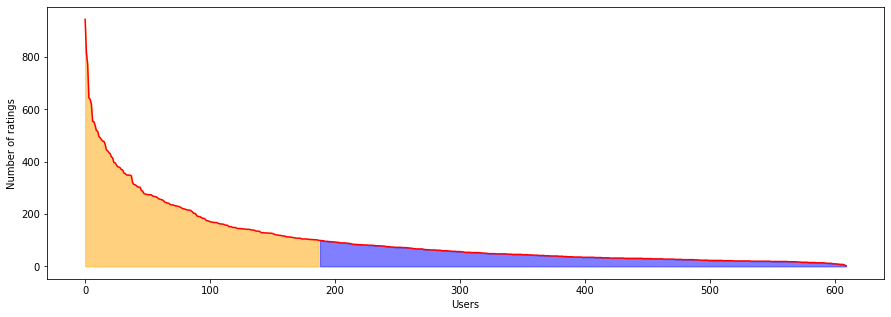

In [22]:
users_count = pd.DataFrame(popular_ratings.groupby('userId').size().sort_values(ascending=False), columns=['count'])
divider = len(users_count.query('count >= @active_users_thresh'))
fig, (ax) = plt.subplots(1, 1, figsize=(15,5))
plt.plot(np.arange(len(users_count)),users_count['count'], color='r')
plt.xlabel('Users')
plt.ylabel('Number of ratings')

ax.fill_between(np.arange(0,divider),
                0,
                users_count['count'][:divider],
                color='orange',
                alpha=0.5)
ax.fill_between(np.arange(divider, len(users_count)),
                0,
                users_count['count'][divider:],
                color='blue',
                alpha=0.5)

## Remove non-active users frm data

In [23]:
active_users_indices=users_count.query('count >= @active_users_thresh').index
active_users_ratings =popular_ratings[popular_ratings['userId'].isin(active_users_indices)]

 **Number of rows in rating data after removing unpopular movies**

In [24]:
popular_ratings.shape[0]

62518

 **Number of rows in rating data after removing unpopular movies and active users**

In [25]:
active_users_ratings.shape[0]

44588

 **Number of users before removing inactive users**

In [26]:
popular_ratings.groupby('userId').count().shape[0]

610

 **Number of users after removing inactive users and unpopular movies**

In [27]:
active_users_ratings.groupby('userId').count().shape[0]

188

 **create a pivot table of rows containing movie id and columns containing userid .The cells in the tabel will contain the rating given by the user to the movie**

In [28]:
pivot_table = active_users_ratings.pivot(index='movieId', columns='userId', values='rating').fillna(0)

 **Number of movies in the pivot table**

In [29]:
pivot_table.index.shape[0]

1050

 **Number of users in the pivot table**

In [30]:
pivot_table.columns.shape[0]

188

In [31]:
pivot_table.head()

userId,1,4,6,7,15,18,19,20,21,22,28,41,42,45,50,51,57,62,63,64,66,68,73,76,80,82,84,89,91,95,100,103,104,105,111,117,119,122,125,129,...,489,495,509,514,517,520,522,524,525,527,534,542,551,552,555,559,560,561,562,567,570,572,573,577,580,586,587,590,594,596,597,599,600,602,603,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,2.5,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,4.0,3.0,0.0,5.0,0.0,5.0,4.0,4.0,2.5,4.5,0.5,0.0,2.5,0.0,3.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,4.0,4.0,4.0,0.0,3.0,4.0,4.0,0.0,4.0,0.0,0.0,0.0,4.0,5.0,3.0,4.0,4.5,3.5,4.0,4.0,5.0,0.0,3.0,0.0,5.0,4.0,0.0,4.0,4.0,3.0,2.5,0.0,4.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,4.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,4.0,3.0,0.0,0.0,3.0,0.0,4.0,4.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.5,4.0,4.5,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,3.5,0.0,4.5,0.0,0.0,4.0,0.0,2.5,4.0,0.0,0.0,2.5,4.0,4.0,0.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,3.5,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.5,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.5,3.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,4.0,0.0,0.0,3.0,4.5,0.0,4.5,0.0,4.0,0.0,0.0,0.0,3.5,4.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,4.5,4.0,4.0,0.0,0.0,3.5,0.0,0.0,3.0,4.5,0.0,3.0,4.0,0.0,0.0,0.0,0.0,5.0


### **Create a sparse matrix from the pivot table**

In [32]:
sparse_matrix = csr_matrix(pivot_table.values)

## **Create dictionaries(mapping) for:**

1.movie title -> movie id

2.movie id -> movie title

In [33]:
pivot_table_movies = movies.set_index('movieId').loc[pivot_table.index]['title'].values
title_to_id = {movie : i for i ,movie in enumerate(pivot_table_movies)}

In [34]:
id_to_title = {v : k for k, v in title_to_id.items()}

# Train the model

 **we use k-nearest algorithm.The sparse matrix is provided as the dataset to the algorithm**

 **Cosine similarity:**
 cosine similarity is a measure between two non zero vectors of an inner product space that measures the cosine of the angle between them

 **why not Euclidian Distance**?
 no of columns in the data is in order of hundreds and the matrix is very sparse.it would be highly inaccurate and inefficient to use eculidian distance

**Note:**
The nearest neighbours algorithm is a lazy learner. we call the fit function here bcz internally, the appropriate data structure to be setup for fast lookup and computation of similarity metric

In [35]:
model_knn = NearestNeighbors(metric='cosine',algorithm='brute')
model_knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

# Get Recommendations

### **Define a function to search for similar movies titles for a given keyword**

The keyword provided may not be exact title of the movie. Therefore we will use the sequencematcher to perform the search.

Here,we will select top 10 similar movie titles for given search keyword

In [39]:
def find_matches(title_to_id, movie_title):
  movie_ids = np.array(list(title_to_id.values())).astype(int)
  titles = np.array (list(title_to_id.keys()))
  ratios = list()
  for title, movie_id in title_to_id.items():
    ratio = SequenceMatcher(None,movie_title, title, autojunk=False).ratio()
    ratios.append(ratio)
  titles,ids = titles[np.argsort(ratios)][-10:], movie_ids[np.argsort(ratios)][-10:]
  return list(reversed(list(zip(titles, ids))))

 **Given a title of a movie , we will display aDropdown to display the options and to select the title**

In [40]:
title = 'batman'
options = find_matches(title_to_id, title)

import ipywidgets as widgets
drop = widgets.Dropdown(options=options)
drop 

Dropdown(options=(('Batman (1989)', 155), ('Batman Begins (2005)', 860), ('Watchmen (2009)', 941), ('Batman & …

### **Show recommendations for a given movie**

For the given movie, the similarity measures b\w the given movie all the samples in the dataset is computed.

n_neighbors how mab=ny similar movies are shown as arecommendation

In [41]:
movie_id =drop.value
test = pivot_table.iloc[movie_id, :].values.reshape(1, -1)

distances, indices = model_knn.kneighbors(test,n_neighbors=10 + 1)

indices = indices.squeeze()[1:]

print('Recommendations for : ', id_to_title[movie_id])
for i, index in enumerate(indices):
  print(i+1, '.', id_to_title[index])

Recommendations for :  Batman (1989)
1 . Jurassic Park (1993)
2 . Terminator 2: Judgment Day (1991)
3 . Star Wars: Episode IV - A New Hope (1977)
4 . Star Wars: Episode VI - Return of the Jedi (1983)
5 . Indiana Jones and the Temple of Doom (1984)
6 . True Lies (1994)
7 . Terminator, The (1984)
8 . Independence Day (a.k.a. ID4) (1996)
9 . Batman Forever (1995)
10 . Indiana Jones and the Last Crusade (1989)
